
## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

##### 2 Représenter la distribution empirique des "fold-change" (**FC**) vs Précision, aka: volcano-plot
    
##### 3 Effectuer une analyse de sur-représentation en termes GO


## Ressources : Rappels et illustration de l'analyse de représentation de termes GO
###### [TP de MADP](https://github.com/glaunay/tp-proteomics#3-obtention-des-param%C3%A8tres-du-mod%C3%A8le)
###### [Fiche Bioconductor](https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html)



### Préparation de  l'environnement

##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [10]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas
import numpy as np

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Jeux de données
* Jeux de données de protéomique quantitative au format TSV
* Ontologie GO au format [owl](http://www.obofoundry.org/ontology/go.html)
* Entrées Uniprot au format XML
    * Protéines de l'étude
    * Protéome d'E.Coli complet
    
<hr style="border:1px solid gray"> </hr>

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ 
Retirer les lignes présentant des aberrations numériques
</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Attention aux types des colonnes !</span>

In [14]:
df = pandas.read_csv("../TCL_wt1.tsv",sep="\t",na_values="#VALEUR!", dtype={"Log2 Corrected Abundance Ratio":"float"})
data_frame = df.dropna()
data_frame

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,0.036746,1.434787
...,...,...,...,...,...,...,...
2011,P77330,Prophage lipoprotein Bor homolog OS=Escherichi...,borD,1.535948,0.619129,0.310725,0.507623
2016,P02930,Outer membrane protein TolC OS=Escherichia col...,tolC,1.552288,0.634396,0.013373,1.873757
2020,P0A917,Outer membrane protein X OS=Escherichia coli (...,ompX,1.579739,0.659686,0.002226,2.652391
2021,P02931,Outer membrane protein F OS=Escherichia coli (...,ompF,1.754902,0.811390,0.000068,4.164956


##### 1. Un premier volcano-plot

Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnée la précision de la mesure.

<span style="color:firebrick;font-weight:bold">$\rhd$ 1. Réaliser un scatter plot matplotlib avec</span>
<br/><span style="color:firebrick;font-weight:bold">- en x, `Log2 Corrected Abundance Ratio`</span>
<br/><span style="color:firebrick;font-weight:bold">-  en y, `LOG10 Adj.P-val`</span>

<span style="color:firebrick;font-weight:bold">$\rhd$Vous légenderez les axes, attention `LOG10 Adj.P-val` est en fait `-LOG10 Adj.P-val`, regardez bien.</span>

##### 2. Réaliser des versions évoluées du graphique précédent
L'objectif est de mettre l'accent sur la région **-Log10 adj Pvalue > 4** et **Log2 corrected abundance ratio > 0**.
<br/>Pour cela vous revisiterez le scatter plot précedent au travers des versions suivantes:
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ première version : un rectangle de la couleur de votre choix matérialisera la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ deuxième version  : une couleur de votre choix représentera les points de la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ troisème version (optionnel): Les identifiants uniprot remplaceront les points des protéines de la région</span>

In [15]:
df2 = data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>0) & (data_frame["LOG10 Adj.P-val"]>4)]
dico_annot = {}
for index, row in df2.iterrows():
    cle = row["Accession"]
    x = row["Log2 Corrected Abundance Ratio"]
    y = row["LOG10 Adj.P-val"]
    dico_annot[cle]=(x,y)
    
    

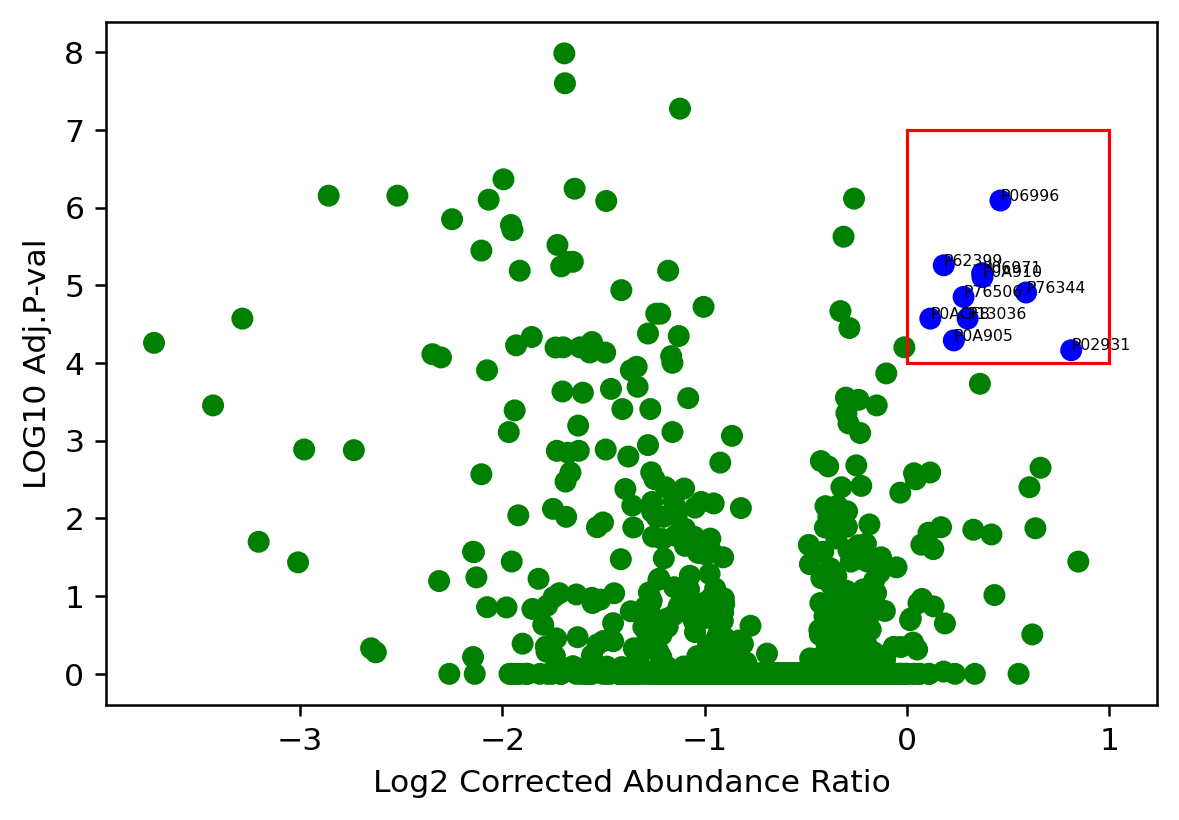

In [16]:
RETINA = 226
x = pandas.to_numeric(data_frame["Log2 Corrected Abundance Ratio"])
y = pandas.to_numeric(data_frame["LOG10 Adj.P-val"])
col = np.where(x<0,'g',np.where(y<4,'g','b'))
fig, ax = plt.subplots(dpi=RETINA)
ax.scatter(x,y,c=col)
ax.set_xlabel("Log2 Corrected Abundance Ratio")
ax.set_ylabel("LOG10 Adj.P-val")
rect = patches.Rectangle((0, 4), 1, 3, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
for i in dico_annot.keys():
    ax.text(dico_annot[i][0],dico_annot[i][1],i,fontsize=5)


#### Analyse ORA

##### Principes
Vous disposez d'un objet analyser permettant de réaliser une analyse de la sur-représentation (**ORA**) en termes GO parmi une liste de protéine d'intérêt.
La fréquence des termes GO dans le protéome totale est utilisée comme référence.

L'objet analyser s'instancie ainsi
```python
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
```

Il fournit une méthode pour chaque catégorie de termes GO
<i>{ biological_process, molecular_function, cellular_component }</i>

Une éventuelle surreprésentation des termes GO de la catégorie <i>biological_process</i> est par exemple calculée parmi les protéines P29744 et P05706 de la façon suivante:

```python
goTerm_scores = o.biological_process(["P29744", "P05706"])
```
<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous.$\downarrow$ </span>
</br><span style="color:firebrick;font-weight:bold"> $\rhd$ Inspecter l'objet retourné par la méthode o.biological_process, que voyez-vous ?</span>

In [17]:
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")

Loading ontology


OwlReadyOntologyParsingError: NTriples parsing error (or unrecognized file format) in /Users/ravy/vdb/VDB_jupyter/exercices/../data/go.owl.

In [9]:
o.biological_process

NameError: name 'o' is not defined

In [18]:
o.proteomeCollection

In [22]:
help(o)

Help on GO_ORA_analyser in module stat_utils object:

class GO_ORA_analyser(builtins.object)
 |  GO_ORA_analyser(goOntologyFile, proteomeDirectory, experimentalProteinDirectory)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, goOntologyFile, proteomeDirectory, experimentalProteinDirectory)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  biological_process(self, selectedUniprotList)
 |  
 |  cellular_component(self, selectedUniprotList)
 |  
 |  molecular_function(self, selectedUniprotList)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



###### 2/ Analyser la représentation des termes GO parmi les protéines surabondantes de l'experience
<span style="color:firebrick;font-weight:bold"> $\rhd$ Vous devrez extraire les identifiants uniprot des protéines aux `Log2 Corrected Abundance Ratio` supérieurs au seuil alpha de 5%.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous conduirez sur cette liste de protéines une analyse de sur-représentation en termes GO à l'aide d'un objet *GO_ORA_analyser*.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous pouvez faire varier le seuil d'abondance autour de la valeur alpha.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous traiterez les 3 catégories *biological_process / molecular_function /cellular_component*.</span>



Familiarisez-vous avec la structures des dictionnaires de résultas, vous pouvez [les sauvegarder au format json](https://docs.python.org/3/library/json.html).


In [9]:
list_id_sup_5 = list(data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>0.05)]["Accession"])
list_id_sup_5 #Liste contenant les id des prot superieur au seuil de 5%
bp_sup5=o.biological_process(list_id_sup_5)
mc_sup5=o.cellular_component(list_id_sup_5)
mf_sup5=o.molecular_function(list_id_sup_5)

Building biological process GO Tree
Extracting biological process ontology
Applying true path collapsing
247 GO terms, 62 leaves, 27 proteins
Extracting biological process ontology
Applying true path collapsing
2728 GO terms, 6650 leaves, 3128 proteins
Evaluated 246 / 246 Pathways, based on 37 proteins
cellular component process GO Tree
Extracting cellular component ontology
Applying true path collapsing
51 GO terms, 78 leaves, 36 proteins
Extracting cellular component ontology
Applying true path collapsing
239 GO terms, 4698 leaves, 2805 proteins
Evaluated 50 / 50 Pathways, based on 37 proteins
molecular function process GO Tree
Extracting molecular function ontology
Applying true path collapsing
81 GO terms, 74 leaves, 23 proteins
Extracting molecular function ontology
Applying true path collapsing
2264 GO terms, 7807 leaves, 3118 proteins
Evaluated 80 / 80 Pathways, based on 37 proteins


In [10]:
seuil = 0.03
while seuil != 0.1 :
    print(f" voici le nouveau seuil {seuil} : \n")
    list_id_sup_seuil = list(data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>seuil)]["Accession"])
    print(o.biological_process(list_id_sup_seuil))
    print(o.cellular_component(list_id_sup_seuil))
    print(o.molecular_function(list_id_sup_seuil))
    print("------------------------------------------------------------------- \n")
    seuil += 0.01

 voici le nouveau seuil 0.03 : 



KeyboardInterrupt: 

In [50]:
print(f"biological process : {bp_sup5[0]} \ncellular component : {mc_sup5[0]} \nmolecular_function : {mf_sup5[0]}")

biological process : (1.277774972034038e-06, 'siderophore transport', 'GO:0015891', ['P13036', 'P06971', 'P75780', 'P02930', 'P05825']) 
cellular component : (6.744103642899227e-22, 'external encapsulating structure part', 'GO:0044462', ['P77774', 'P0A940', 'P0A937', 'P09169', 'P05825', 'P0A937', 'P06996', 'P0A940', 'P09169', 'P05825', 'P0A915', 'P39180', 'P0A905', 'P76471', 'P76506', 'P13036', 'P0A927', 'P10384', 'P06971', 'P0A910', 'P0A908', 'P75780', 'P06996', 'P06129', 'P02930', 'P0A917', 'P02931', 'P0AB40']) 
molecular_function : (1.7979035567056582e-07, 'channel activity', 'GO:0015267', ['P05825', 'P10384', 'P0A910', 'P06996', 'P06129', 'P02930', 'P02931', 'P0A927', 'P10384', 'P06129', 'P02930', 'P02931'])


In [81]:
bp_sup5

[(1.277774972034038e-06,
  'siderophore transport',
  'GO:0015891',
  ['P13036', 'P06971', 'P75780', 'P02930', 'P05825']),
 (6.023913047836394e-06,
  'iron coordination entity transport',
  'GO:1901678',
  ['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']),
 (5.532051927766727e-05,
  'iron ion transport',
  'GO:0006826',
  ['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']),
 (0.0001270732486959893,
  'ion transport',
  'GO:0006811',
  ['P0A927',
   'P0A910',
   'P13036',
   'P05825',
   'P05825',
   'P13036',
   'P06971',
   'P75780',
   'P02930',
   'P0AER8',
   'P06996',
   'P76506',
   'P0A910',
   'P06129',
   'P02930',
   'P02931']),
 (0.00023017691092962867,
  'membrane organization',
  'GO:0061024',
  ['P77774', 'P0A940', 'P0A937', 'P77774', 'P0A940', 'P0A937', 'P76506']),
 (0.00038932504762125263,
  'protein insertion into membrane',
  'GO:0051205',
  ['P77774', 'P0A940', 'P0A937']),
 (0.0006094525728954648,
  'Gram-negative-bacterium-type cell o

## Une première application: représentation riche du résultat de l'analyse


### Mise en forme "riche" des résultats grâce au notebook

Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML.
 Ainsi, tout objet impémentant une méthode **_repr_html_()** sera affiché, via son rendu HTML, dans la cellule d'un notebook.

```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)
```
Affichera

![caption](../figs/reprhtml.png)


### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, implémenter une classe Rich_GO_ORA dont la méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) permettra un affichage plus lisible d'une des analyses `biological_process / molecular_function /cellular_component`

Un exemple possible est,
![caption](../figs/_repr_html_.png)

(Bonus): clicker sur le nom du terme GO envoie vers sa description.
Pour cela, afficher le nom du pathway dans une balise hyperlien pour permettre d'acceder à la page de description du terme GO. 

Les termes GO sont accessibles aux URL de la forme
`http://amigo.geneontology.org/amigo/term/GO:GO_NUMBER`.




In [11]:
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)

Abscisse,Ordonnée,Cote
2,3,4


In [101]:
bp_sup5

[(1.277774972034038e-06,
  'siderophore transport',
  'GO:0015891',
  ['P13036', 'P06971', 'P75780', 'P02930', 'P05825']),
 (6.023913047836394e-06,
  'iron coordination entity transport',
  'GO:1901678',
  ['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']),
 (5.532051927766727e-05,
  'iron ion transport',
  'GO:0006826',
  ['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']),
 (0.0001270732486959893,
  'ion transport',
  'GO:0006811',
  ['P0A927',
   'P0A910',
   'P13036',
   'P05825',
   'P05825',
   'P13036',
   'P06971',
   'P75780',
   'P02930',
   'P0AER8',
   'P06996',
   'P76506',
   'P0A910',
   'P06129',
   'P02930',
   'P02931']),
 (0.00023017691092962867,
  'membrane organization',
  'GO:0061024',
  ['P77774', 'P0A940', 'P0A937', 'P77774', 'P0A940', 'P0A937', 'P76506']),
 (0.00038932504762125263,
  'protein insertion into membrane',
  'GO:0051205',
  ['P77774', 'P0A940', 'P0A937']),
 (0.0006094525728954648,
  'Gram-negative-bacterium-type cell o

In [12]:
class Rich_GO_ORA() :
    def __init__(self,bio_proc):
        self.bio_proc = bio_proc
    def _repr_html_(self) :
        htmlString = "<table><thead><tr><td>P-Value</td><td>Activity</td><td>GO_ID</td><td>List_Value</td><td>GO_Term</td></tr></thead>"
        for i in self.bio_proc :
            htmlString += f"<tbody><tr><td>{i[0]}</td><td>{i[1]}</td><td>{i[2]}</td><td>{i[3]}</td><td><a href = http://amigo.geneontology.org/amigo/term/{i[2]}>{i[2]}</a></td></tr></tbody>"
        htmlString += "</table>"
        return htmlString
        

Rich_GO_ORA(bp_sup5)

P-Value,Activity,GO_ID,List_Value,GO_Term
1.277774972034038e-06,siderophore transport,GO:0015891,"['P13036', 'P06971', 'P75780', 'P02930', 'P05825']",GO:0015891
6.023913047836394e-06,iron coordination entity transport,GO:1901678,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:1901678
5.532051927766727e-05,iron ion transport,GO:0006826,"['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:0006826
0.0001270732486959893,ion transport,GO:0006811,"['P0A927', 'P0A910', 'P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930', 'P0AER8', 'P06996', 'P76506', 'P0A910', 'P06129', 'P02930', 'P02931']",GO:0006811
0.00023017691092962867,membrane organization,GO:0061024,"['P77774', 'P0A940', 'P0A937', 'P77774', 'P0A940', 'P0A937', 'P76506']",GO:0061024
0.00038932504762125263,protein insertion into membrane,GO:0051205,"['P77774', 'P0A940', 'P0A937']",GO:0051205
0.0006094525728954648,Gram-negative-bacterium-type cell outer membrane assembly,GO:0043165,"['P77774', 'P0A940', 'P0A937']",GO:0043165
0.0006094525728954648,membrane assembly,GO:0071709,"['P77774', 'P0A940', 'P0A937']",GO:0071709
0.0007440622520732061,establishment of protein localization to membrane,GO:0090150,"['P77774', 'P0A940', 'P0A937']",GO:0090150
0.0009756392518373065,iron ion homeostasis,GO:0055072,"['P13036', 'P06971', 'P75780', 'P05825', 'P05825']",GO:0055072


## Une deuxième application: volcano plot améliorés
###### PANDAS
En choisissant comme seuil la valeur `alpha` du TP précédent, veuillez extraires les identifiants uniprot des protéines sur-abondantes (rappel les valeurs d'abondance sont celles de la colonne `Log2 Corrected Abundance Ratio`).

Vous devrez avoir dans des listes distinctes:
* identifiants uniprot
* `Log2 Corrected Abundance Ratio`
* `LOG10 Adj.P-val'`

###### Représentation graphiques
* Pour la catégorie de termes GO (biological_process / molecular_function /cellular_component) de votre choix
    * Générer une grille de 4 graphiques 
    * Dans chaque graphique colorez dans une couleur différentes les protéines porteuses de 4 termes de GO que vous estimez les plus pertinents 
    * Donnez le nom de la catégorie générale à la grille
    * Donnez le nom du terme GO représenté dans chaque graphique avec une couleur de titre cohérente.
    

In [13]:
#Seuil alpha récupéré du TP précédent
alpha = 0.096
#Création des listes
list_alpha_id=list(data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>alpha)]["Accession"])
list_alpha_log2=list(data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>alpha)]["Log2 Corrected Abundance Ratio"])
list_alpha_log10=list(data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>alpha)]["LOG10 Adj.P-val"])
list_go_alpha=o.biological_process(list_alpha_id)

Evaluated 240 / 246 Pathways, based on 31 proteins


In [14]:
Rich_GO_ORA(list_go_alpha)

P-Value,Activity,GO_ID,List_Value,GO_Term
5.132796457470556e-07,siderophore transport,GO:0015891,"['P13036', 'P06971', 'P75780', 'P02930', 'P05825']",GO:0015891
2.4428321153130882e-06,iron coordination entity transport,GO:1901678,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:1901678
1.702919516842175e-05,ion transport,GO:0006811,"['P0A927', 'P0A910', 'P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930', 'P0AER8', 'P06996', 'P76506', 'P0A910', 'P06129', 'P02930', 'P02931']",GO:0006811
2.2898132422704963e-05,iron ion transport,GO:0006826,"['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:0006826
0.0004937509848459438,iron ion homeostasis,GO:0055072,"['P13036', 'P06971', 'P75780', 'P05825', 'P05825']",GO:0055072
0.0009163623570639523,phospholipid transport,GO:0015914,"['P06996', 'P76506']",GO:0015914
0.0009336084540530498,transition metal ion homeostasis,GO:0055076,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055076
0.0010134716686980576,metal ion homeostasis,GO:0055065,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055065
0.0017056788235080562,cofactor transport,GO:0051181,"['P02930', 'P05825', 'P06129']",GO:0051181
0.0019618936312202793,cation homeostasis,GO:0055080,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055080


Text(0.5, 0.98, 'protein with the best value')

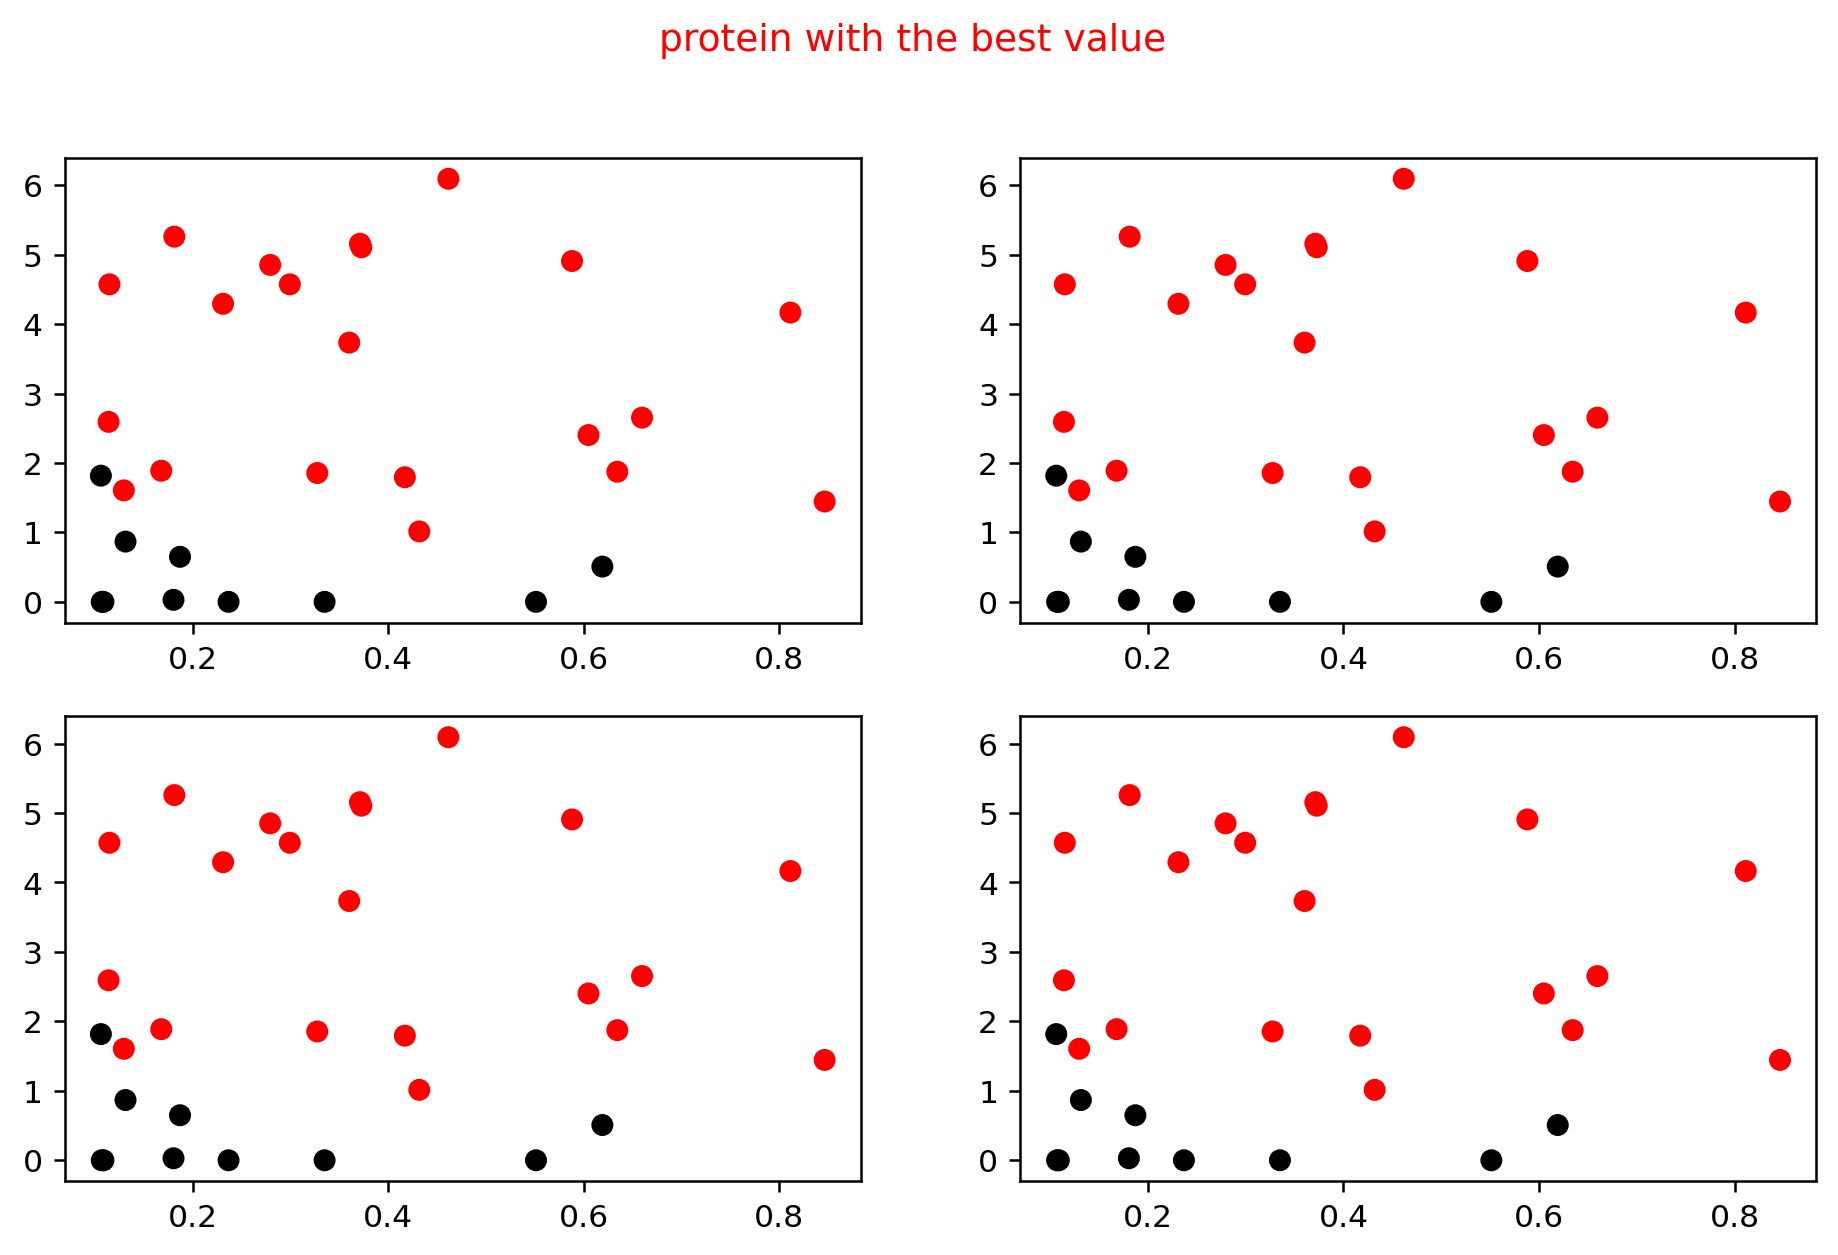

In [125]:
#Représentation graphiques
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,6), ncols=2, nrows=2, dpi = 226)
function_col = [ "red" if x>0.106309 and y>1.014018 else "black" for x,y in zip(list_alpha_log2,list_alpha_log10)]
ax1.scatter(list_alpha_log2,list_alpha_log10,c=function_col)
ax2.scatter(list_alpha_log2,list_alpha_log10,c=function_col)f
ax3.scatter(list_alpha_log2,list_alpha_log10,c=function_col)
ax4.scatter(list_alpha_log2,list_alpha_log10,c=function_col)
fig1.suptitle("protein with the best value",color="red")

In [60]:
chr()

'a'

In [76]:
import random
nb_10,lettre_10=[i for i in range(10)],[chr(i) for i in range(65,97) ]
random.shuffle(nb_10)
random.shuffle(lettre_10)
dic={i : j for i,j in zip(nb_10,lettre_10)}
dic

{8: 'Z',
 2: 'M',
 3: 'I',
 5: '`',
 1: 'D',
 0: 'W',
 7: ']',
 9: '[',
 4: 'B',
 6: 'T'}

In [81]:
list_go_alpha[1]

(2.4428321153130882e-06,
 'iron coordination entity transport',
 'GO:1901678',
 ['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930'])

In [80]:
Rich_GO_ORA(sorted(list_go_alpha,key=lambda x : x[0] ))

P-Value,Activity,GO_ID,List_Value,GO_Term
5.132796457470556e-07,siderophore transport,GO:0015891,"['P13036', 'P06971', 'P75780', 'P02930', 'P05825']",GO:0015891
2.4428321153130882e-06,iron coordination entity transport,GO:1901678,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:1901678
1.702919516842175e-05,ion transport,GO:0006811,"['P0A927', 'P0A910', 'P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930', 'P0AER8', 'P06996', 'P76506', 'P0A910', 'P06129', 'P02930', 'P02931']",GO:0006811
2.2898132422704963e-05,iron ion transport,GO:0006826,"['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']",GO:0006826
0.0004937509848459438,iron ion homeostasis,GO:0055072,"['P13036', 'P06971', 'P75780', 'P05825', 'P05825']",GO:0055072
0.0009163623570639523,phospholipid transport,GO:0015914,"['P06996', 'P76506']",GO:0015914
0.0009336084540530498,transition metal ion homeostasis,GO:0055076,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055076
0.0010134716686980576,metal ion homeostasis,GO:0055065,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055065
0.0017056788235080562,cofactor transport,GO:0051181,"['P02930', 'P05825', 'P06129']",GO:0051181
0.0019618936312202793,cation homeostasis,GO:0055080,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780']",GO:0055080


In [82]:
biggest_pvalue=sorted(list_go_alpha,key=lambda x : x[0] )[0]

In [85]:
list_id_b=biggest_pvalue[3]

In [ ]:
data_frame[(data_frame["Log2 Corrected Abundance Ratio"]>0) & (data_frame["LOG10 Adj.P-val"]>4)]

In [106]:
log2=[]
log10=[]
for i in list_id_b :
    log2.append(data_frame[(data_frame["Accession"]==i)]["Log2 Corrected Abundance Ratio"])
    log10.append(data_frame[(data_frame["Accession"]==i)]["LOG10 Adj.P-val"])

In [113]:
log2
log10

[1984    4.571899
 Name: LOG10 Adj.P-val, dtype: float64,
 1992    5.156463
 Name: LOG10 Adj.P-val, dtype: float64,
 2001    1.014018
 Name: LOG10 Adj.P-val, dtype: float64,
 2016    1.873757
 Name: LOG10 Adj.P-val, dtype: float64,
 1962    1.816916
 Name: LOG10 Adj.P-val, dtype: float64]